In [55]:
# load data
import numpy as np
import pandas as pd
# df = pd.read_excel('OuterHarbour-Tiel.xlsx')
# df = pd.read_excel('OuterHarbour-Tiel2.xlsx')
df = pd.read_excel('OuterHarbour-Tiel3.xlsx')

In [56]:
# All nodes on the route
locs = df[["locationType", "cityName", "countryName"]].to_numpy().astype('str')
nodes = np.unique(locs, axis=0)
# create columns with default value for now
for node in nodes:
    df[f'{node[0]}_{node[1]}_{node[2]}_visited'] = False
    df[f'{node[0]}_{node[1]}_{node[2]}_planned'] = False

In [57]:
df = df[df["ordSeaFreightMainTransportInvolvement"] == "J"]
df["ordJFHArrangeLoadingPickup"].fillna("", inplace=True)
df["ordJFHArrangeDelivery"].fillna("", inplace=True)
df["ordReqDeliveryDate"].fillna("", inplace=True)

In [58]:
from math import sqrt, pow

def node_name(node):
    # node = node.iloc[0]
    return f'{node["locationType"]}_{node["cityName"]}_{node["countryName"]}'

def abs_distance(o, lat, long):
    # o = origin_node.iloc[0]
    diff_lat = abs(o["latitude"] - lat) * 111.139
    diff_long =  abs(o["longitude"] - long) * 111.139
    res = sqrt(pow(diff_lat, 2) + pow(diff_long, 2))
    return res if res != 0 else 1

def dep_late(port, node_created):
    if node_created > port["actualDepDate"]:
        return "yes" if port["actualDepDate"] > port["estimatedDepDate"] else "no"
    return "unknown"
    

def get_created_date(rowNo, destination, ordCreate, reqPortL, reqPortD, origDest, locType, readyDate, actArrDate):
    if rowNo == 1:
        return ordCreate
    elif rowNo == destination["rowNo"]:
        return ordCreate
    elif origDest == "O" and locType.strip() == "P":
        return ordCreate if reqPortL else readyDate
    elif origDest == "D" and locType.strip() == "P":
        return ordCreate if reqPortD else readyDate
    return actArrDate

def get_port(port, node_created):
    return node_name(port) if node_created >= port["created"] else "unknown"

df["origin"] = [df.loc[(df["shipmentID"] == shipmentID) & (df["rowNo"] == 1)].iloc[0] for shipmentID in df["shipmentID"]]
df["originCountry"] = [o["countryName"] for o in df["origin"]]
df["destination"] = [df.loc[(df["shipmentID"] == shipmentID) & (df["rowNo"] == df[df["shipmentID"] == shipmentID]["rowNo"].max())].iloc[0] for shipmentID in df["shipmentID"]]
df["destinationCountry"] = [d["countryName"] for d in df["destination"]]
df["created"] = [get_created_date(*values) for values in df[["rowNo", "destination", "ordaCreateDate", "prtReqPOL", "prtReqPOD", "originDestination", "locationType", "readyDate", "actualArrDate"]].values]
df["created"] = df["created"].astype(object)
df["readyDate"] = [o["readyDate"] for o in df["origin"]]
df["consolidation"] = (df["ordtType"].str.strip() == "LF") | (df["ordtType"].str.strip() == "LFL")
df["deconsolidation"] = df["ordtType"].str.strip() == "LFL"
df["serviceType"] = [f"{'door' if p == 'Y' else 'port'}-to-{'door' if d == 'Y' else 'port'}" for p, d in df[["ordJFHArrangeLoadingPickup", "ordJFHArrangeDelivery"]].values]
df["pastTimeToOrigin"] = [orig["actualDepDate"] - arr_date for orig, arr_date in df[["origin", "actualArrDate"]].values]
df["pastTimeToOrigin"] = df["pastTimeToOrigin"] / pd.Timedelta(hours=1)
df["pastAvgAbsSpeed"] = [past_time / abs_distance(orig, lat, long) for (lat, long, orig, past_time) in df[["latitude", "longitude", "origin", "pastTimeToOrigin"]].values]
df["counterStops"] = df["rowNo"] - 1
df["departureOrigin"] = [o["actualDepDate"] if (i > 1 and o["actualDepDate"] > created) else None for (o, created, i) in df[["origin", "created", "rowNo"]].values]
df["numberOfTEU"] = df["ordExpectedNBOfContainers"]
df["totalWeight"] = df["ordGrossWeightKGM"]
df["ETA"] = df["ordReqDeliveryDate"]
df["ATA"] = [df.loc[(df["shipmentID"] == shipmentID) & (df["rowNo"] == df[df["shipmentID"] == shipmentID]["rowNo"].max())].iloc[0]["actualArrDate"] for shipmentID in df["shipmentID"]]
df["currentMonth"] = [c.month for c in df["created"].values]
df["portOfLoading"] = [get_port(df.loc[(df["shipmentID"] == shipmentID) & (df["locationType"].str.strip() == "P") & (df["originDestination"].str.strip() == "O")].iloc[0], created) for (shipmentID, created) in df[["shipmentID", "created"]].values]
df["portOfDischarge"] = [get_port(df.loc[(df["shipmentID"] == shipmentID) & (df["locationType"].str.strip() == "P") & (df["originDestination"].str.strip() == "D")].iloc[0], created) for (shipmentID, created) in df[["shipmentID", "created"]].values]
df["portDestCongestion"] = 0 # external source needed
df["portOfLoadingLate"] = [dep_late(df.loc[(df["shipmentID"] == shipmentID) & (df["locationType"].str.strip() == "P") & (df["originDestination"].str.strip() == "O")].iloc[0], created) for (shipmentID, created) in df[["shipmentID", "created"]].values]
df["origin"] = [node_name(o) for o in df["origin"]]
df["destination"] = [node_name(d) for d in df["destination"]]
# set visited path and future path
ss = np.unique(df["shipmentID"])
paths = [df[df["shipmentID"] == s][["locationType", "cityName", "countryName"]].apply(lambda x : node_name(x), axis=1) for s in ss]
for path, shipment in zip(paths, ss):
    for i in range(1, len(path) + 1):
        df.loc[(df["shipmentID"] == shipment) & (df["rowNo"] == i), [f"{n}_visited" for n in path[:i]]] = True
        df.loc[(df["shipmentID"] == shipment) & (df["rowNo"] == i), [f"{n}_planned" for n in path[i-1:]]] = True
# convert datetime to number of days 
df["departureOrigin"] = pd.to_datetime(df["departureOrigin"])
df["ATA"] = df["ATA"] - df["departureOrigin"]
df["ETA"] = df["ETA"] - df["departureOrigin"]
df["departureMonthOrigin"] = df["departureOrigin"].apply(lambda x : x.month)
df["departureDayOrigin"] = df["departureOrigin"].apply(lambda x : x.isoweekday())

In [59]:

df = df.drop(columns=["departureOrigin", "estimatedDepDate", "created", "readyDate", "estimatedArrDate", "actualDepDate", "prtReqPOL", "prtReqPOD", "ordReqShipDate", "ordaCreateDate", "ordReqDeliveryDate", "latitude" , "longitude", "actualArrDate", "ordExpectedNBOfContainers", "ordGrossWeightKGM", "rowNo", "shipmentID", "originDestination", "locationType", "cityName", "countryName", "ordtType", "ordJFHArrangeLoadingPickup", "ordSeaFreightMainTransportInvolvement", "ordJFHArrangeDelivery"])

In [60]:
df.replace([np.inf, -np.inf], 0, inplace=True)
df["departureMonthOrigin"].fillna(0, inplace=True)
df["departureDayOrigin"].fillna(0, inplace=True)

df = df.astype({
    "origin" : 'category',
    "originCountry" : 'category',
    "destination" : 'category',
    "destinationCountry" : 'category',
    "serviceType" : 'category',
    "portOfLoading" : 'category',
    "portOfLoadingLate" : 'category',
    "portOfDischarge" : 'category',
    "departureMonthOrigin" : 'int64',
    "departureDayOrigin" : 'int64',
    "consolidation" : "int",
    "deconsolidation" : "int"
})
df["ATA"] = df["ATA"] / pd.Timedelta(hours=1)
df["ETA"] = df["ETA"] / pd.Timedelta(hours=1)
for node in nodes:
    df[f'{node[0]}_{node[1]}_{node[2]}_visited'] = df[f'{node[0]}_{node[1]}_{node[2]}_visited'].astype(int)
    df[f'{node[0]}_{node[1]}_{node[2]}_planned'] = df[f'{node[0]}_{node[1]}_{node[2]}_planned'].astype(int)
df["origin"] = df["origin"].factorize()[0]
df["originCountry"] = df["originCountry"].factorize()[0]
df["destination"] = df["destination"].factorize()[0]
df["destinationCountry"] = df["destinationCountry"].factorize()[0]
df["portOfLoading"] = df["portOfLoading"].factorize()[0]
df["portOfLoadingLate"] = df["portOfLoadingLate"].factorize()[0]
df["portOfDischarge"] = df["portOfDischarge"].factorize()[0]
df["serviceType"] = df["serviceType"].factorize()[0]

In [70]:
from sklearn import svm
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

feature_names = df.columns

scaler = StandardScaler()
scaler.fit(df)
scaler.transform(df)

y = df["ATA"]
X = df.drop(columns=["ATA"])

X.fillna(0, inplace=True)
y.fillna(0, inplace=True)

regr = svm.SVR(kernel='linear')
selector = RFE(regr, n_features_to_select=20, step=5)
selector = selector.fit(X, y)
supported_features = [(feature, rank) for feature, support, rank in zip(X.columns, selector.support_, selector.ranking_) if support]
supported_features

[('A _Outer Harbour_Australia_planned', 1),
 ('A _Tiel_Netherlands_visited', 1),
 ('D _Maasvlakte_Netherlands_visited', 1),
 ('D _Maasvlakte_Netherlands_planned', 1),
 ('D _Outer Harbor_Australia_visited', 1),
 ('P _Adelaide_Australia_visited', 1),
 ('P _Adelaide_Australia_planned', 1),
 ('P _Rotterdam_Netherlands_visited', 1),
 ('P1_Gioia Tauro_Italy_visited', 1),
 ('P1_Le Havre_France_visited', 1),
 ('P1_Le Havre_France_planned', 1),
 ('P1_Valencia_Spain_visited', 1),
 ('P2_Antwerpen_Belgium_visited', 1),
 ('serviceType', 1),
 ('pastTimeToOrigin', 1),
 ('pastAvgAbsSpeed', 1),
 ('counterStops', 1),
 ('ETA', 1),
 ('departureMonthOrigin', 1),
 ('departureDayOrigin', 1)]

Text(0.5, 0, 'Permutation Importance')

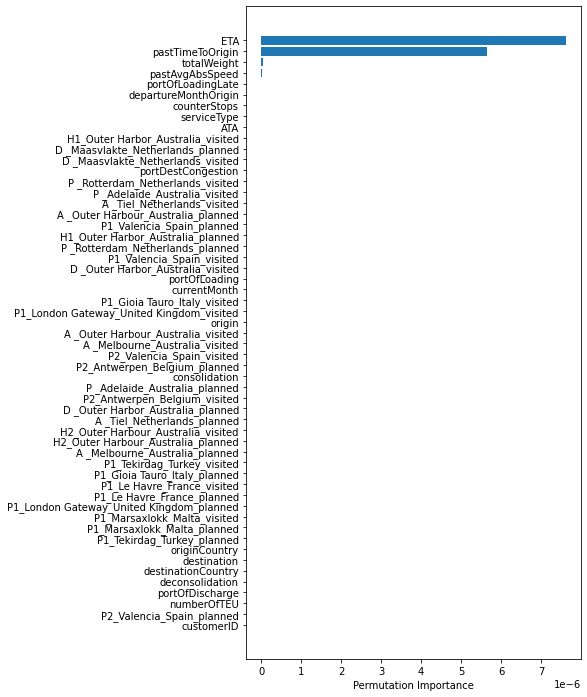

In [62]:
from sklearn import svm
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

regr = svm.SVR(kernel='rbf')
regr.fit(X, y)
perm_importance = permutation_importance(regr, X, y)

features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(6, 12))
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])

plt.xlabel("Permutation Importance")

In [63]:
df.to_excel("output.xlsx")

Text(0.5, 1.0, 'Features Correlation with Actual Time of Arrival')

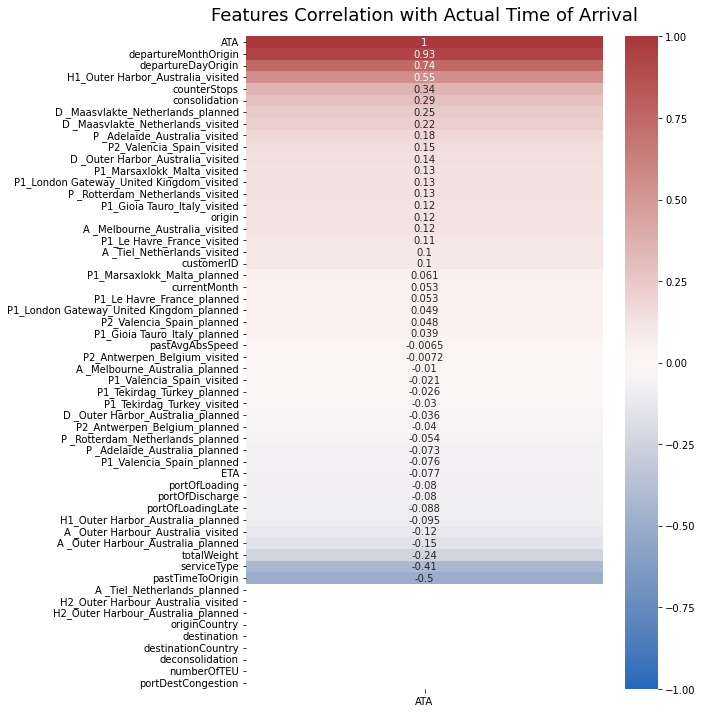

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 12))
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
heatmap = sns.heatmap(df.corr()[['ATA']].sort_values(by='ATA', ascending=False), vmin=-1, vmax=1, annot=True, cmap='vlag')
heatmap.set_title('Features Correlation with Actual Time of Arrival', fontdict={'fontsize':18}, pad=16)